In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

In [2]:
%matplotlib inline
np.random.seed(1)

In [3]:
X_train_orig,y_train_orig,X_test_orig,y_test_orig,classes=load_dataset()

y=2


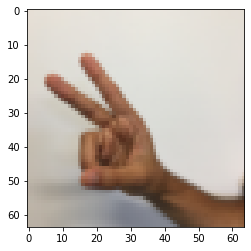

In [21]:
index =6
plt.imshow(X_train_orig[index])
print('y='+str(np.squeeze(y_train_orig[:,index])))

In [17]:
X_train = X_train_orig/255.
X_test = X_test_orig
Y_train = convert_to_one_hot(y_train_orig, 6).T
Y_test = convert_to_one_hot(y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

conv_layers={}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [6]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X=tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    y=tf.placeholder(tf.float32,shape=(None,n_y))

    return X,y

In [7]:
X,y=create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [8]:
def initialize_parameters():

    tf.set_random_seed(1)

    W1=tf.get_variable('W1',[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable('W2',[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters={
        'W1':W1,
        'W2':W2
    }

    return parameters

In [19]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print(parameters['W1'].eval())
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

[[[[ 0.11547081 -0.15562162  0.14463945 -0.12213563 -0.161331
     0.0167321   0.00137798  0.15687598]
   [ 0.06261188  0.15809353 -0.13944083  0.1304368   0.14947264
     0.07770665 -0.0344099   0.02789916]
   [ 0.1310067   0.03547595  0.1019934   0.17467071 -0.16157703
    -0.06069881 -0.10278072 -0.06633689]]

  [[-0.1701455  -0.15981087 -0.06383926 -0.00349012 -0.14234345
    -0.05761932  0.00821769 -0.07173218]
   [ 0.14097519  0.11141728  0.18437327  0.0588678  -0.13764857
    -0.11404216  0.05882488  0.09655331]
   [ 0.09364428 -0.03100704  0.16560768  0.14417745  0.15409656
    -0.08602516 -0.12028332 -0.16772161]]

  [[ 0.18019755 -0.17030357 -0.10018802 -0.18330556  0.03716455
    -0.09169444 -0.01606575 -0.10697315]
   [-0.1352132   0.04067522  0.07451691  0.02565144 -0.08935398
    -0.14955646  0.17125843 -0.10636543]
   [ 0.1641133  -0.16645104  0.14331098 -0.0984499  -0.02071032
    -0.13608913  0.15722917 -0.05736801]]

  [[ 0.18048044  0.12755601  0.09927674 -0.07896702

In [10]:
def forward_propagation(X,parameters):
    W1=parameters['W1']
    W2=parameters['W2']

    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    #给定输入和一组滤波器，函数将使用的滤波器卷积X。第三个输入([1,f,f,1])表示输入的每个维度(m, n_H_prev, n_W_prev, n_C_prev)的步幅。
    
    A1=tf.nn.relu(Z1)

    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    #给定输入A，此函数使用大小为（f，f）的窗口和大小为（s，s）的步幅在每个窗口上进行最大池化。

    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')

    A2=tf.nn.relu(Z2)

    P2=tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')

    P2=tf.contrib.layers.flatten(P2)
    #给定输入P，此函数将每个示例展平为一维向量，同时保持批量大小。它返回维度为[batch_size，k]的展平张量。

    Z3=tf.contrib.layers.fully_connected(P2,num_outputs=6,activation_fn=None)
    #给定展平的输入F，它将返回用全连接层计算出的输出。  
    #全连接层会自动初始化图中的权重，并在训练模型时继续对其进行训练

    return Z3

In [11]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X,y=create_placeholders(64,64,3,6)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    init=tf.global_variables_initializer()
    sess.run(init)
    a=sess.run(Z3,{X:np.random.randn(2,64,64,3),y:np.random.randn(2,6)})
    print('Z3:'+str(a))

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Z3:[[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


In [12]:
def compute_cost(Z3,y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=y))

    return cost

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X,y=create_placeholders(64,64,3,6)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    cost=compute_cost(Z3,y)
    init=tf.global_variables_initializer()
    sess.run(init)
    a=sess.run(cost,{X:np.random.randn(4,64,64,3),y:np.random.randn(4,6)})
    print('cost='+str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost=4.6648703


In [14]:
def model(X_train,y_train,X_test,y_test,learning_rate=0.009,num_epochs=100,minibatch_size=64,print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=y_train.shape[1]
    costs=[]

    X,y=create_placeholders(n_H0,n_W0,n_C0,n_y)

    parameters=initialize_parameters()

    Z3=forward_propagation(X,parameters)

    cost=compute_cost(Z3,y)

    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init=tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost=0
            num_minibatches=int(m/minibatch_size)
            minibatches=random_mini_batches(X_train,y_train,minibatch_size,seed)

            for minibatch in minibatches:

                (minibatch_X,minibatch_y)=minibatch
                _,temp_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,y:minibatch_y})

                minibatch_cost+=temp_cost/num_minibatches


            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op=tf.argmax(Z3,1)
        correct_prediction=tf.equal(predict_op,tf.argmax(y,1))

        accuracy=tf.reduce_mean(tf.cast(correct_prediction,'float'))
        print('accuracy=',accuracy)
        train_accuracy=accuracy.eval({X:X_train,y:y_train})
        test_accuracy=accuracy.eval({X:X_test,y:y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy,test_accuracy,parameters
        

In [15]:
def model1(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [16]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 41.472049
Cost after epoch 5: 1.903686
Cost after epoch 10: 1.903567
Cost after epoch 15: 1.903488
Cost after epoch 20: 1.903359


KeyboardInterrupt: 

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784077
Cost after epoch 30: 1.681052
Cost after epoch 35: 1.618207
Cost after epoch 40: 1.597972
Cost after epoch 45: 1.566707
Cost after epoch 50: 1.554487
Cost after epoch 55: 1.502187
Cost after epoch 60: 1.461035
Cost after epoch 65: 1.304477
Cost after epoch 70: 1.201501
Cost after epoch 75: 1.144229
Cost after epoch 80: 1.098368
Cost after epoch 85: 1.080149
Cost after epoch 90: 1.044141
Cost after epoch 95: 1.012781


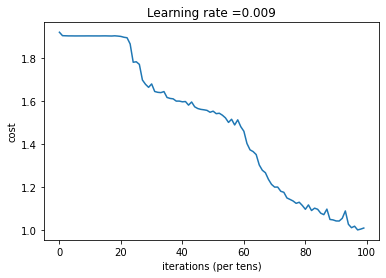

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6722222
Test Accuracy: 0.55


In [ ]:
_, _, parameters = model1(X_train, Y_train, X_test, Y_test)